In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sms-spam-collection-dataset/spam.csv


In [1]:
import pandas as pd

df = pd.read_csv('/kaggle/input/sms-spam-collection-dataset/spam.csv', encoding='latin-1')[['v1', 'v2']]
df.columns = ['label', 'message']

print(df.head())
print(df['label'].value_counts())


  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...
label
ham     4825
spam     747
Name: count, dtype: int64


In [2]:
#preproc
import numpy as np
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.util import ngrams
from collections import Counter

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
#helper func
def tokenize(text):
    return nltk.word_tokenize(text)

def remove_stopwords(tokens):
    return [w for w in tokens if w.lower() not in stop_words and w.isalpha()]

def preprocess_basic(text):
    tokens = tokenize(text.lower())
    filtered = remove_stopwords(tokens)
    return filtered

def get_ngrams(tokens, n):
    return [' '.join(gram) for gram in ngrams(tokens, n)]

def get_top_ngrams(messages, n=1, top_k=10):
    all_ngrams = []
    for msg in messages:
        tokens = preprocess_basic(msg)
        grams = get_ngrams(tokens, n)
        all_ngrams.extend(grams)
    return Counter(all_ngrams).most_common(top_k)


In [4]:
#eda
for label in ['ham', 'spam']:
    print(f"Top words for {label}:")
    print(get_top_ngrams(df[df['label'] == label]['message'], n=1))  # Words
    print(f"Top bigrams for {label}:")
    print(get_top_ngrams(df[df['label'] == label]['message'], n=2))
    print(f"Top trigrams for {label}:")
    print(get_top_ngrams(df[df['label'] == label]['message'], n=3))


Top words for ham:
[('u', 979), ('gt', 318), ('lt', 316), ('get', 301), ('go', 248), ('ok', 245), ('got', 242), ('ur', 237), ('know', 236), ('like', 231)]
Top bigrams for ham:
[('lt gt', 276), ('gon na', 58), ('call later', 50), ('let know', 39), ('sorry call', 38), ('r u', 37), ('u r', 35), ('good morning', 31), ('take care', 31), ('u wan', 29)]
Top trigrams for ham:
[('sorry call later', 38), ('lt decimal gt', 23), ('gt lt gt', 18), ('happy new year', 18), ('lt gt lt', 16), ('like lt gt', 14), ('pls send message', 13), ('cant pick phone', 12), ('pick phone right', 12), ('phone right pls', 12)]
Top words for spam:
[('call', 346), ('free', 219), ('txt', 156), ('ur', 144), ('u', 141), ('mobile', 123), ('text', 121), ('stop', 114), ('claim', 113), ('reply', 104)]
Top bigrams for spam:
[('please call', 45), ('po box', 24), ('guaranteed call', 23), ('prize guaranteed', 22), ('call landline', 22), ('selected receive', 19), ('send stop', 19), ('every week', 19), ('await collection', 19), ('c

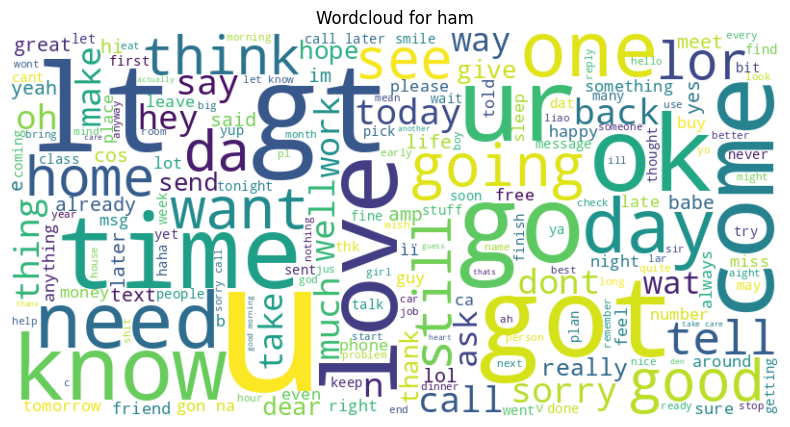

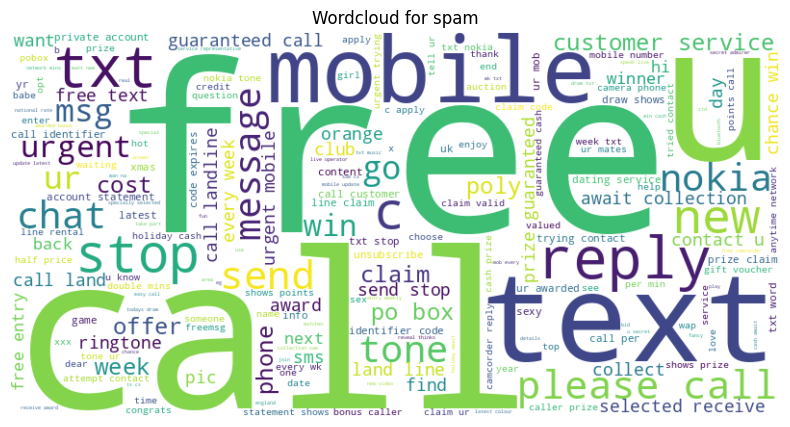

In [5]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

for label in ['ham', 'spam']:
    text = ' '.join(df[df['label'] == label]['message'])
    tokens = preprocess_basic(text)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(tokens))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Wordcloud for {label}')
    plt.show()


In [6]:
#BoW
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(df['message'], df['label'], test_size=0.2, random_state=42, stratify=df['label'])

# BoW vectorizer
bow = CountVectorizer(stop_words='english')
X_train_bow = bow.fit_transform(X_train)
X_test_bow = bow.transform(X_test)

# Model
clf_bow = LogisticRegression(max_iter=1000)
clf_bow.fit(X_train_bow, y_train)
pred_bow = clf_bow.predict(X_test_bow)

f1_bow = f1_score(y_test, pred_bow, pos_label='spam')
print('F1-score (BoW):', f1_bow)


F1-score (BoW): 0.9044117647058824


In [7]:
#TfIDF
from sklearn.feature_extraction.text import TfidfVectorizer

# Tf-IDF vectorizer
tfidf = TfidfVectorizer(stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Model
clf_tfidf = LogisticRegression(max_iter=1000)
clf_tfidf.fit(X_train_tfidf, y_train)
pred_tfidf = clf_tfidf.predict(X_test_tfidf)

f1_tfidf = f1_score(y_test, pred_tfidf, pos_label='spam')
print('F1-score (TF-IDF):', f1_tfidf)


F1-score (TF-IDF): 0.8625954198473283


In [8]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def preprocess_advanced(text):
    # Lowercase
    text = text.lower()
    # Remove email-ids, urls, html tags
    text = re.sub(r'\\S+@\\S+|http\\S+|<.*?>', '', text)
    # Remove numbers and punctuations
    text = re.sub(r'\\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize and remove stopwords
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words and w.isalpha()]
    return ' '.join(tokens)

# Apply preprocessing
X_train_cleaned = X_train.apply(preprocess_advanced)
X_test_cleaned = X_test.apply(preprocess_advanced)

# Tf-IDF on cleaned text
tfidf_clean = TfidfVectorizer()
X_train_clean = tfidf_clean.fit_transform(X_train_cleaned)
X_test_clean = tfidf_clean.transform(X_test_cleaned)

clf_clean = LogisticRegression(max_iter=1000)
clf_clean.fit(X_train_clean, y_train)
pred_clean = clf_clean.predict(X_test_clean)

f1_clean = f1_score(y_test, pred_clean, pos_label='spam')
print('F1-score (TF-IDF + Preprocessing):', f1_clean)


F1-score (TF-IDF + Preprocessing): 0.8416988416988417


In [9]:
pd.DataFrame({
    'Method': ['Bag-of-Words', 'TF-IDF', 'TF-IDF + Preprocessing'],
    'F1-Score': [f1_bow, f1_tfidf, f1_clean]
})


,Method,F1-Score
0,Bag-of-Words,0.904412
1,TF-IDF,0.862595
2,TF-IDF + Preprocessing,0.841699
